# 01. Pytorch Workflow Fundamentals

![Pytorch Workflow](./assets/01_a_pytorch_workflow.png)

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.8.0'

## 1. Data (preparing and loading)

![Data Preprocessing](./assets/01_data_preapring_and_loading.png)

Two Parts : 
1. Turn your data, whatever it is, into numbers (a representation)
2. Pick or build a model to learn the representation as best as possible.

known parameters: things that can be learned by a model

In [18]:
# let's create some data

# creating known parameters
weight = 0.7
bias = 0.3

# creating data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias

print(X[:10], "\n", y[:10])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) 
 tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


Now we are going to build a model that can learn the relationship between X (features) and y (labels)

### Split data into training and test sets


- | Split          | Total Data | 
- | Training set   - 60-80%     |
- | Validation Set -  10-20%     |
- | Testing Set    -  10-20%     |

In [19]:
# creating the training and testing splits
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(len(X_train), len(y_train), len(X_test), len(y_test))

40 40 10 10


But right now our data is just numbers on a page.

Let's create a function to visualize it.



In [20]:
def plot_predictions(train_data=X_train,
                    train_label=y_train,
                    test_data = X_test,
                    test_label = y_test,
                    predictions = None):
    
    """Plots training data, test data and compares predictions"""
    plt.figure(figsize=(5,5))
    plt.scatter(train_data, train_label, c='b', s=4, label='Training Data')
    plt.scatter(test_data, test_label, c='g', s=4, label='Testing Data')
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")
    # Show the legend
    plt.legend(prop={"size": 10})

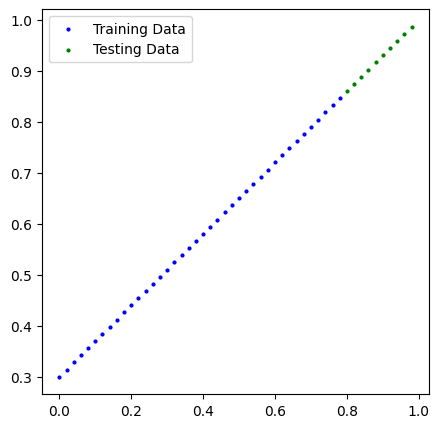

In [21]:
plot_predictions()

## 2. Build Model

![Pytorch Model building Essentials](./assets/01_model_building_essentials.png)

- nn.Module contains the larger building blocks (layers)
- nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
- forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
- torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data


In [27]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor :
        return self.weights*x + self.bias

![Model in Depth](./assets/01-pytorch-linear-model-annotated.png)

In [28]:
torch.manual_seed(42)

# Creating an instance of the model (which is a subclass of nn.Module that contains nn.Parameters)
model_0 = LinearRegressionModel()

# Check the nn.Parameters within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [29]:
# We can also the get the `state` i.e. what the model contains using `.state_dict()`
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

In [32]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# """
# Or using this : 
# with torch.no_grad():
#     y_preds = model_0(X_test)
# """

We have used `torch.inference_mode()` as [`context manager`](https://realpython.com/python-with-statement/)

- As the name suggests, torch.inference_mode() is used when using a model for inference (making predictions).

- torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

In [33]:
# Check the predictions
print(f"Number of Testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted Values: \n{y_preds}")

Number of Testing samples: 10
Number of predictions made: 10
Predicted Values: 
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


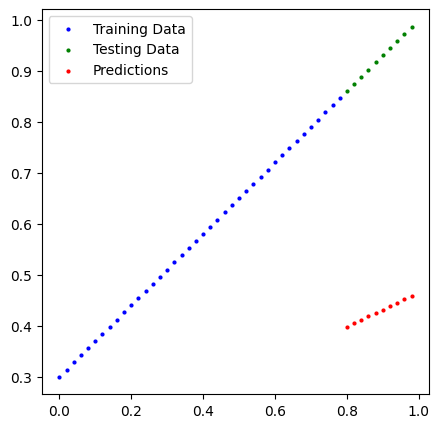

In [34]:
plot_predictions(predictions=y_preds)

In [35]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## 3. Train Model